# Working with Numba

[Numba](https://numba.pydata.org/) is an accelerator library for Python, which just-in time compiles Python code into fast machine code. If used right, its performance can be close to optimized C code. Moreover, it supports offloading of kernels to GPU devices and shared memory parallelism.

The following example from the Numba homepage provides a very first idea of what Numba does.

In [2]:
from numba import njit, jit
from numpy import arange

# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit(nopython=True)
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(9).reshape(3,3)
print(sum2d(a))

36.0


On its first call the `sum2d` function is just-in-time compiled into fast executable code and then executed. All that is needed is the decorator `@njit`.

In the following we want to use Numba to compute the Mandelbrot fractal and measure its performance. First, we define a simple convenient timer in Python.

In [3]:
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

Time to create fractal: 14.145000219345093


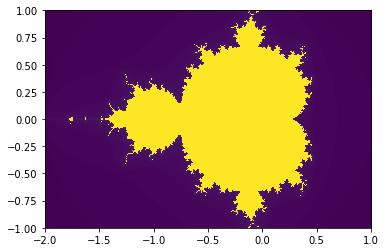

In [4]:
%matplotlib inline

#from __future__ import print_function, division, absolute_import
import numpy as np
from pylab import imshow, jet, show, ion

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((2000, 3000), dtype=np.uint8)

with Timer() as t:
    mandelbrot = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
print("Time to create fractal: {0}".format(t.interval))
    
imshow(mandelbrot, extent=[-2, 1, -1, 1])

This is fairly slow. The problem is that we have three nested for-loops. In each inner iteration a call to the Python interpeter needs to be performed. Python is not designed for speedy handling of such loop constructs. However, we can improve it by enabling Just-In-Time compilation of the routines with Numba. This is done in the following code, where the `@njit` keyword was added.

Time to create fractal: 0.31102871894836426


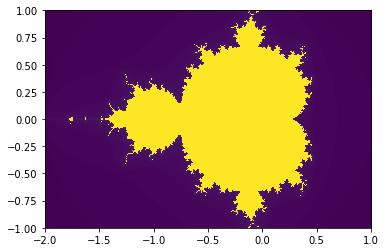

In [5]:
%matplotlib inline

from numba import jit
import numpy as np
from pylab import imshow, jet, show, ion

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((2000, 3000), dtype=np.uint8)

with Timer() as t:
    mandelbrot = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
print("Time to create fractal: {0}".format(t.interval))
    
imshow(mandelbrot, extent=[-2, 1, -1, 1])

Time to create fractal: 0.03600764274597168


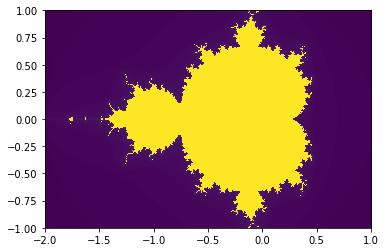

In [6]:
%matplotlib inline

from numba import njit, prange
import numpy as np
from pylab import imshow, jet, show, ion

@njit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@njit(['uint8[:,:](float64, float64, float64, float64, uint8[:, :], uint8)'], parallel=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in prange(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color
    return image

image = np.zeros((2000, 3000), dtype=np.uint8)

with Timer() as t:
    mandelbrot = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
print("Time to create fractal: {0}".format(t.interval))

imshow(mandelbrot, extent=[-2, 1, -1, 1])

The key to the parallelization is the `prange` command in the for-loop. This is similar to the parallel for-loop in low-level shared memory parallel libraries such as OpenMP and tells Numba to spread out the computation to multiple CPU cores. However, it is essential that Numba knows all data types, so that no Python calls will be performed during the parallel loop.

We can easily inspect the code that Numba generates. Consider the following simple function.

In [7]:
@njit
def mysum(a, b):
    return a + b

c = mysum(3, 4)

We can now inspect the generated LLVM code for this function.

In [8]:
for v, k in mysum.inspect_llvm().items():
    print(v, k)

(int64, int64) ; ModuleID = 'mysum'
source_filename = "<string>"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-pc-windows-msvc"

@"_ZN08NumbaEnv8__main__9mysum$248Exx" = common local_unnamed_addr global i8* null
@.const.mysum = internal constant [6 x i8] c"mysum\00"
@PyExc_RuntimeError = external global i8
@".const.missing Environment" = internal constant [20 x i8] c"missing Environment\00"

; Function Attrs: norecurse nounwind writeonly
define i32 @"_ZN8__main__9mysum$248Exx"(i64* noalias nocapture %retptr, { i8*, i32 }** noalias nocapture readnone %excinfo, i64 %arg.a, i64 %arg.b) local_unnamed_addr #0 {
entry:
  %.14 = add nsw i64 %arg.b, %arg.a
  store i64 %.14, i64* %retptr, align 8
  ret i32 0
}

define i8* @"_ZN7cpython8__main__9mysum$248Exx"(i8* nocapture readnone %py_closure, i8* %py_args, i8* nocapture readnone %py_kws) local_unnamed_addr {
entry:
  %.5 = alloca i8*, align 8
  %.6 = alloca i8*, align 8
  %.7 = call i32 (i8*, i8*, i64, i64

Numba has a number of features to not only target CPUs, but also GPU architectures. It is a fast moving project and widely used to speed up Python code to levels that were previously only known in languages such as C and Fortran, making it possible to combine the ease of Fortran with the performance of low-level languages.